In [0]:
%run ./includes/utilities

In [0]:
%run ./includes/configuration

/mnt/dscc202-datasets has been unmounted.
/mnt/dscc202-group09-datasets has been unmounted.

Variable Name Value 
 CLASS_DATA_PATH /mnt/dscc202-datasets 
 GROUP_DATA_PATH /mnt/dscc202-group09-datasets 
 BASE_DELTA_PATH /mnt/dscc202-group09-datasets/flightdelay/tables/ 
 GROUP_DBNAME dscc202_group09_db 
 CLASS_DBNAME dscc202_db

In [0]:
# import libraries
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, NullType
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import StandardScaler, Imputer
from pyspark.sql import functions as f
from pyspark.sql.window import Window
from pyspark.sql import SQLContext
import pyspark.ml.feature as ftr
from pathlib import Path

import pandas as pd
import requests
import timezonefinder
import pandas_profiling
from pandas_profiling.utils.cache import cache_file

# import libraries
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, NullType
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import StandardScaler, Imputer
from pyspark.sql import functions as f
from pyspark.sql.window import Window
from pyspark.sql import SQLContext
import pyspark.ml.feature as ftr
from pathlib import Path

import requests
import timezonefinder
import pandas_profiling
from pandas_profiling.utils.cache import cache_file

# Libraries for modeling
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml import PipelineModel
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import PCA

import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline
import mlflow
import mlflow.spark
from pyspark.sql.types import StructType, StringType, IntegerType, TimestampType, DoubleType
from pyspark.sql.functions import col, split, lit

from pyspark.sql.functions import *
from graphframes import *
from pyspark.sql.functions import lit, col
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import to_date
from pyspark.sql.functions import date_format
import pyspark.sql.functions as F
from pyspark.sql import SparkSession

In [0]:
from datetime import datetime as dt
from datetime import timedelta

#dbutils.widgets.removeAll()

dbutils.widgets.dropdown("00.Airport_Code", "JFK", ["JFK","SEA","BOS","ATL","LAX","SFO","DEN","DFW","ORD","CVG","CLT","DCA","IAH"])
airport_code = str(dbutils.widgets.get('00.Airport_Code'))
print(airport_code)

#For presentation time limit, define training start date: 2018-01-01, end date 2019-06-30 before covid.
training_end_date = '2019-06-30'
training_start_date = '2018-01-01'
inference_date = '2019-07-01'


SFO

In [0]:
airports = spark.sql("select * from dscc202_group09_db.airport_loc_csv")
display(airports)

ind id ident type name latitude_deg longitude_deg elevation_ft continent iso_country iso_region municipality scheduled_service gps_code iata_code local_code home_link wikipedia_link keywords 30329 16091 KABQ large_airport Albuquerque International Sunport 35.0402 -106.609 5355.0 null US US-NM Albuquerque yes KABQ ABQ ABQ http://www.abqsunport.com/ https://en.wikipedia.org/wiki/Albuquerque_International_Sunport null 30348 3364 KADW large_airport Joint Base Andrews 38.8108 -76.867 280.0 null US US-MD Camp Springs no KADW ADW ADW http://www.jba.af.mil/ https://en.wikipedia.org/wiki/Joint_Base_Andrews Andrews Air Force Base 30361 3366 KAFW large_airport Fort Worth Alliance Airport 32.9876 -97.3188 722.0 null US US-TX Fort Worth no KAFW AFW AFW http://www.allianceairport.com/ https://en.wikipedia.org/wiki/Fort_Worth_Alliance_Airport null 30365 3368 KAGS large_airport Augusta Regional At Bush Field 33.3699 -81.9645 144.0 null US US-GA Augusta yes KAGS AGS AGS null https://en.wikipedia.org/wiki/Augusta_Regional_Airport null 30398 3377 KAMA large_airport Rick Husband Amarillo International Airport 35.2194 -101.706 3607.0 null US US-TX Amarillo yes KAMA AMA AMA http://airport.amarillo.gov/ https://en.wikipedia.org/wiki/Rick_Husband_Amarillo_International_Airport null 30452 3384 KATL large_airport Hartsfield Jackson Atlanta International Airport 33.6367 -84.4281 1026.0 null US US-GA Atlanta yes KATL ATL ATL http://www.atlanta-airport.com/ https://en.wikipedia.org/wiki/Hartsfield–Jackson_Atlanta_International_Airport null 30461 3386 KAUS large_airport Austin Bergstrom International Airport 30.1945 -97.6699 542.0 null US US-TX Austin yes KAUS AUS AUS http://www.ci.austin.tx.us/austinairport/ https://en.wikipedia.org/wiki/Austin-Bergstrom_International_Airport null 30465 3387 KAVL large_airport Asheville Regional Airport 35.4362 -82.5418 2165.0 null US US-NC Asheville yes KAVL AVL AVL null https://en.wikipedia.org/wiki/Asheville_Regional_Airport null 30489 3391 KBAB large_airport Beale Air Force Base 39.1361 -121.437 113.0 null US US-CA Marysville no KBAB BAB BAB null https://en.wikipedia.org/wiki/Beale_Air_Force_Base null 30490 3392 KBAD large_airport Barksdale Air Force Base 32.5018 -93.6627 166.0 null US US-LA Bossier City no KBAD BAD BAD null https://en.wikipedia.org/wiki/Barksdale_Air_Force_Base null 30507 3396 KBDL large_airport Bradley International Airport 41.9389 -72.6832 173.0 null US US-CT Hartford yes KBDL BDL BDL http://www.bradleyairport.com/ https://en.wikipedia.org/wiki/Bradley_International_Airport HFD, Hartford 30522 3401 KBFI large_airport Boeing Field King County International Airport 47.53 -122.302 21.0 null US US-WA Seattle yes KBFI BFI BFI null https://en.wikipedia.org/wiki/Boeing_Field null 30532 3405 KBGR large_airport Bangor International Airport 44.8074 -68.8281 192.0 null US US-ME Bangor yes KBGR BGR BGR null https://en.wikipedia.org/wiki/Bangor_International_Airport null 30537 3406 KBHM large_airport Birmingham-Shuttlesworth International Airport 33.5629 -86.7535 650.0 null US US-AL Birmingham yes KBHM BHM BHM http://www.flybirmingham.com/ https://en.wikipedia.org/wiki/Birmingham_International_Airport_(US) null 30543 3408 KBIL large_airport Billings Logan International Airport 45.8077 -108.543 3652.0 null US US-MT Billings yes KBIL BIL BIL null https://en.wikipedia.org/wiki/Billings_Logan_International_Airport null 30565 3417 KBLV large_airport Scott AFB/Midamerica Airport 38.5452 -89.8352 459.0 null US US-IL Belleville yes KBLV BLV BLV null https://en.wikipedia.org/wiki/Scott_Air_Force_Base Scott Air Force Base 30569 3419 KBMI large_airport Central Illinois Regional Airport at Bloomington-Normal 40.4771 -88.9159 871.0 null US US-IL Bloomington/Normal yes KBMI BMI BMI null https://en.wikipedia.org/wiki/Central_Illinois_Regional_Airport null 30573 3420 KBNA large_airport Nashville International Airport 36.1245 -86.6782 599.0 null US US-TN Nashville yes KBNA BNA BNA null https://en.wikipedia.org/wiki/Nashville_In

In [0]:
tmp = airports.select(["ident", "name"]).distinct().toPandas()
airport_dict = tmp.set_index('ident')['name'].to_dict()

In [0]:
bronze_airtraffic = spark.sql("select * from dscc202_db.bronze_air_traffic where CANCELLED = 0")
#bronze_airtraffic = bronze_airtraffic.na.drop()
bronze_airtraffic = bronze_airtraffic.filter(bronze_airtraffic.DEST_STATE_ABR.isNotNull())
df_base = bronze_airtraffic.filter((bronze_airtraffic.DEST == airport_code) | (bronze_airtraffic.ORIGIN == airport_code)).filter(bronze_airtraffic.FL_DATE < inference_date).filter(bronze_airtraffic.FL_DATE >= training_start_date)
display(df_base)

YEAR QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID OP_CARRIER TAIL_NUM OP_CARRIER_FL_NUM ORIGIN_AIRPORT_ID ORIGIN_AIRPORT_SEQ_ID ORIGIN_CITY_MARKET_ID ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR ORIGIN_STATE_FIPS ORIGIN_STATE_NM ORIGIN_WAC DEST_AIRPORT_ID DEST_AIRPORT_SEQ_ID DEST_CITY_MARKET_ID DEST DEST_CITY_NAME DEST_STATE_ABR DEST_STATE_FIPS DEST_STATE_NM DEST_WAC CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK TAXI_OUT WHEELS_OFF WHEELS_ON TAXI_IN CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DELAY_NEW ARR_DEL15 ARR_DELAY_GROUP ARR_TIME_BLK CANCELLED CANCELLATION_CODE DIVERTED CRS_ELAPSED_TIME ACTUAL_ELAPSED_TIME AIR_TIME FLIGHTS DISTANCE DISTANCE_GROUP CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY FIRST_DEP_TIME TOTAL_ADD_GTIME LONGEST_ADD_GTIME DIV_AIRPORT_LANDINGS DIV_REACHED_DEST DIV_ACTUAL_ELAPSED_TIME DIV_ARR_DELAY DIV_DISTANCE DIV1_AIRPORT DIV1_AIRPORT_ID DIV1_AIRPORT_SEQ_ID DIV1_WHEELS_ON DIV1_TOTAL_GTIME DIV1_LONGEST_GTIME DIV1_WHEELS_OFF DIV1_TAIL_NUM DIV2_AIRPORT DIV2_AIRPORT_ID DIV2_AIRPORT_SEQ_ID DIV2_WHEELS_ON DIV2_TOTAL_GTIME DIV2_LONGEST_GTIME DIV2_WHEELS_OFF DIV2_TAIL_NUM DIV3_AIRPORT DIV3_AIRPORT_ID DIV3_AIRPORT_SEQ_ID DIV3_WHEELS_ON DIV3_TOTAL_GTIME DIV3_LONGEST_GTIME DIV3_WHEELS_OFF DIV3_TAIL_NUM DIV4_AIRPORT DIV4_AIRPORT_ID DIV4_AIRPORT_SEQ_ID DIV4_WHEELS_ON DIV4_TOTAL_GTIME DIV4_LONGEST_GTIME DIV4_WHEELS_OFF DIV4_TAIL_NUM DIV5_AIRPORT DIV5_AIRPORT_ID DIV5_AIRPORT_SEQ_ID DIV5_WHEELS_ON DIV5_TOTAL_GTIME DIV5_LONGEST_GTIME DIV5_WHEELS_OFF DIV5_TAIL_NUM 2018 4 12 4 2 2018-12-04 DL 19790 DL N375DA 2751 14771 1477104 32457 SFO San Francisco, CA CA 6 California 91 12892 1289208 32575 LAX Los Angeles, CA CA 6 California 91 1925 1924 -1.0 0.0 0.0 -1 1900-1959 43.0 2007 2105 7.0 2056 2112 16.0 16.0 1.0 1 2000-2059 0.0 null 0.0 91.0 108.0 58.0 1.0 337.0 2 0.0 0.0 16.0 0.0 0.0 null null null 0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 2018 4 12 5 3 2018-12-05 DL 19790 DL N3766 1048 14771 1477104 32457 SFO San Francisco, CA CA 6 California 91 12892 1289208 32575 LAX Los Angeles, CA CA 6 California 91 1721 1729 8.0 8.0 0.0 0 1700-1759 34.0 1803 1904 5.0 1850 1909 19.0 19.0 1.0 1 1800-1859 0.0 null 0.0 89.0 100.0 61.0 1.0 337.0 2 0.0 0.0 19.0 0.0 0.0 null null null 0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 2018 4 12 5 3 2018-12-05 DL 19790 DL N776DE 1081 14771 1477104 32457 SFO San Francisco, CA CA 6 California 91 12892 1289208 32575 LAX Los Angeles, CA CA 6 California 91 1512 1509 -3.0 0.0 0.0 -1 1500-1559 53.0 1602 1702 5.0 1632 1707 35.0 35.0 1.0 2 1600-1659 0.0 null 0.0 80.0 118.0 60.0 1.0 337.0 2 0.0 0.0 35.0 0.0 0.0 null null null 0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 2018 4 12 5 3 2018-12-05 DL 19790 DL N385DN 1709 14771 1477104 32457 SFO San Francisco, CA CA 6 California 91 12892 1289208 32575 LAX Los Angeles, CA CA 6 California 91 920 913 -7.0 0.0 0.0 -1 0900-0959 38.0 951 1046 16.0 1051 1102 11.0 11.0 0.0 0 1000-1059 0.0 null 0.0 91.0 109.0 55.0 1.0 337.0 2 null null null null null null null null 0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 2018 4 12 5 3 2018-12-05 DL 19790 DL N3733Z 2066 14771 1477104 32457 SFO San Francisco, CA CA 6 California 91 12892 1289208 32575 LAX Los Angeles, CA CA 6 California 91 600 

In [0]:
air_col = ['UNI_ID', 'MONTH','DAY_OF_MONTH','DAY_OF_WEEK','DEP_HOUR','ARR_HOUR','FLIGHT_PATH','FL_DATE',
 'ORIGIN','DEST',
 'CRS_DEP_TIME','DEP_TIME','DEP_DELAY','DEP_DEL15','DEP_DELAY_GROUP','DEP_TIME_BLK',
 'CRS_ARR_TIME','ARR_TIME','ARR_DELAY','ARR_DEL15','ARR_DELAY_GROUP','ARR_TIME_BLK',
 'TAXI_OUT','WHEELS_OFF','WHEELS_ON','TAXI_IN',
 'ACTUAL_ELAPSED_TIME', 'AIR_TIME','DISTANCE','DISTANCE_GROUP',
 'CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY',
 'arr_avg_temp_f','arr_tot_precip_mm','arr_avg_wnd_mps','arr_avg_vis_m','arr_avg_slp_hpa','arr_avg_dewpt_f',
 'dep_avg_temp_f','dep_tot_precip_mm','dep_avg_wnd_mps','dep_avg_vis_m','dep_avg_slp_hpa','dep_avg_dewpt_f']

In [0]:
airlines = spark.sql("select * from dscc202_group09_db.airlines_silver")
airlines = airlines.filter(col("FL_DATE")<=training_end_date).withColumn('UNI_ID', 
                    F.concat(F.col('FLIGHT_PATH'),F.lit('_'), F.col('FL_DATE'))).select(air_col).fillna({'ARR_DEL15':0, 'CARRIER_DELAY':0, 'WEATHER_DELAY':0,'NAS_DELAY':0,'SECURITY_DELAY':0, 'LATE_AIRCRAFT_DELAY':0})
display(airlines)

UNI_ID MONTH DAY_OF_MONTH DAY_OF_WEEK DEP_HOUR ARR_HOUR FLIGHT_PATH FL_DATE ORIGIN DEST CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DEL15 ARR_DELAY_GROUP ARR_TIME_BLK TAXI_OUT WHEELS_OFF WHEELS_ON TAXI_IN ACTUAL_ELAPSED_TIME AIR_TIME DISTANCE DISTANCE_GROUP CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY arr_avg_temp_f arr_tot_precip_mm arr_avg_wnd_mps arr_avg_vis_m arr_avg_slp_hpa arr_avg_dewpt_f dep_avg_temp_f dep_tot_precip_mm dep_avg_wnd_mps dep_avg_vis_m dep_avg_slp_hpa dep_avg_dewpt_f LAX-DEN_2019-03-05 3 5 2 2019-03-05T15:00:00.000+0000 2019-03-05T18:00:00.000+0000 LAX-DEN 2019-03-05 LAX DEN 1434 1500 26.0 1.0 1 1400-1459 1746 1807 21.0 1.0 1 1700-1759 14.0 1514 1757 10.0 127.0 103.0 862.0 4 2.0 0.0 0.0 0.0 19.0 24.08 0.0 3.1 16093.0 1030.5 12.920000000000002 53.96 0.0 3.6 12875.0 1015.8 46.94 LAX-DEN_2019-03-05 3 5 2 2019-03-05T10:00:00.000+0000 2019-03-05T13:00:00.000+0000 LAX-DEN 2019-03-05 LAX DEN 1100 1055 -5.0 0.0 -1 1100-1159 1421 1359 -22.0 0.0 -2 1400-1459 13.0 1108 1352 7.0 124.0 104.0 862.0 4 null null null null null 1.0399999999999991 0.0 1.5 8047.0 1032.5 -2.020000000000003 50.0 0.0 1.5 16093.0 1015.6 46.04 LAX-DEN_2019-03-05 3 5 2 2019-03-05T08:00:00.000+0000 2019-03-05T11:00:00.000+0000 LAX-DEN 2019-03-05 LAX DEN 824 822 -2.0 0.0 -1 0800-0859 1155 1144 -11.0 0.0 -1 1100-1159 10.0 832 1120 24.0 142.0 108.0 862.0 4 null null null null null 5.0 0.0 4.6 9656.0 1031.1 1.9400000000000013 51.980000000000004 0.0 2.6 16093.0 1016.2 46.04 LAX-DEN_2019-03-05 3 5 2 2019-03-05T21:00:00.000+0000 2019-03-05T00:00:00.000+0000 LAX-DEN 2019-03-05 LAX DEN 2015 2106 51.0 1.0 3 2000-2059 2334 35 61.0 1.0 4 2300-2359 37.0 2143 27 8.0 149.0 104.0 862.0 4 3.0 0.0 10.0 0.0 48.0 10.04 0.0 2.6 16093.0 1027.6 3.0199999999999996 60.08 0.0 5.1 14484.0 1015.6 51.08 LAX-DEN_2019-03-06 3 6 3 2019-03-06T15:00:00.000+0000 2019-03-06T18:00:00.000+0000 LAX-DEN 2019-03-06 LAX DEN 1434 1509 35.0 1.0 2 1400-1459 1746 1809 23.0 1.0 1 1700-1759 17.0 1526 1805 4.0 120.0 99.0 862.0 4 7.0 0.0 0.0 0.0 16.0 33.98 0.0 3.1 9656.0 1014.1 21.92 55.04 3.3 6.2 4023.0 1013.5 53.06 LAX-DEN_2019-03-06 3 6 3 2019-03-06T11:00:00.000+0000 2019-03-06T14:00:00.000+0000 LAX-DEN 2019-03-06 LAX DEN 1100 1116 16.0 1.0 1 1100-1159 1421 1416 -5.0 0.0 -1 1400-1459 17.0 1133 1411 5.0 120.0 98.0 862.0 4 null null null null null 19.939999999999998 0.0 3.1 8047.0 1017.4 15.98 57.019999999999996 0.0 1.5 16093.0 1012.2 51.980000000000004 LAX-DEN_2019-03-06 3 6 3 2019-03-06T08:00:00.000+0000 2019-03-06T11:00:00.000+0000 LAX-DEN 2019-03-06 LAX DEN 824 817 -7.0 0.0 -1 0800-0859 1155 1116 -39.0 0.0 -2 1100-1159 18.0 835 1111 5.0 119.0 96.0 862.0 4 null null null null null 17.96 0.0 0.0 9656.0 1016.9 14.0 57.92 0.5 2.1 16093.0 1012.5 51.980000000000004 LAX-DEN_2019-03-06 3 6 3 2019-03-06T21:00:00.000+0000 2019-03-06T00:00:00.000+0000 LAX-DEN 2019-03-06 LAX DEN 2015 2132 77.0 1.0 5 2000-2059 2334 32 58.0 1.0 3 2300-2359 13.0 2145 25 7.0 120.0 100.0 862.0 4 0.0 0.0 0.0 0.0 58.0 24.08 0.0 3.6 14484.0 1025.9 19.04 60.980000000000004 0.0 6.7 9656.0 1014.2 57.019999999999996 LAX-DEN_2019-03-13 3 13 3 2019-03-13T07:00:00.000+0000 2019-03-13T10:00:00.000+0000 LAX-DEN 2019-03-13 LAX DEN 2015 712 657.0 1.0 12 2000-2059 2334 1039 665.0 1.0 12 2300-2359 22.0 734 1031 8.0 147.0 117.0 862.0 4 0.0 657.0 8.0 0.0 0.0 41.0 0.5 5.7 805.0 982.9 39.92 55.94 0.0 2.1 16093.0 1009.8 50.0 LAX-DEN_2019-03-10 3 10 7 2019-03-10T11:00:00.000+0000 2019-03-10T14:00:00.000+0000 LAX-DEN 2019-03-10 LAX DEN 1100 1104 4.0 0.0 0 1100-1159 1421 1405 -16.0 0.0 -2 1400-1459 9.0 1113 1357 8.0 121.0 104.0 862.0 4 null null null null null 32.0 0.0 3.1 16093.0 1017.1 21.92 48.019999999999996 0.0 1.5 16093.0 1013.2 39.92 LAX-DEN_2019-03-10 3 10 7 2019-03-10T08:00:00.000+0000 2019-03-10T11:00:00.000+0000 LAX-DEN 2019-03-10 LAX DEN 824 824 0.0 0.0 0 0800-0859 1155 1127 -28.0 0.0 -2 1100-1159 10.0 834 1121 6.0 123.0 107.0 862.0 4 null null nul

In [0]:
#DEPARTURE DELAY
tripVertices = bronze_airtraffic.withColumnRenamed("ORIGIN", "id").select("id").distinct()
tripEdges = bronze_airtraffic.select(col("ORIGIN_AIRPORT_SEQ_ID").alias("tripId"),col("DEP_DELAY").alias("delay"), col("ORIGIN").alias("src"), col("DEST").alias("dst"), split(col("DEST_CITY_NAME"), ',')[0].alias("city_dst"), col("DEST_STATE_ABR").alias("state_dst"))
tripGraph = GraphFrame(tripVertices,tripEdges)
#to be passed by the main widgets
#airport_code = 'SFO'
display(tripGraph.edges.filter((col("src") == lit(airport_code)) &(col("delay") > 0))\
        .groupBy("state_dst")\
        .avg("delay")\
        .sort(desc("avg(delay)")))

state_dst avg(delay) IA 69.94642857142857 SD 62.5 AL 60.0 WY 54.979069767441864 AR 52.12761904761905 NM 49.54439024390244 OK 49.54364471669219 ID 48.656363636363636 NE 48.62315789473684 MT 48.24627875507443 NY 44.73654778178203 CA 43.11060562323191 UT 42.946354883081156 IN 42.76280834914611 OR 42.077024285949236 AZ 40.73911865631208 WA 40.02362824888422 MA 39.843878148799064 NJ 38.69345032472019 KY 38.52477249747219 NV 38.04501873752859 CO 37.822670191672174 FL 37.54110378050058 OH 37.317147192716234 MO 37.130575831305755 IL 36.819146571841316 TX 36.636049147083384 TN 35.87672493100276 MN 34.32819332566168 PA 33.896117096970926 LA 33.84423676012461 AK 32.49629629629629 HI 32.00064457908985 WI 31.056417489421722 MI 30.934285714285714 NC 30.668648172611185 VA 29.680131119805434 MD 29.6079869600652 CT 28.694444444444443 GA 28.40889547813195 SC 24.0

In [0]:
ranks = tripGraph.pageRank(resetProbability=0.15, maxIter=5)
display(ranks.vertices.orderBy(ranks.vertices.pagerank.desc()).limit(50))

id pagerank ATL 20.37291017148485 ORD 17.417410798314535 DFW 15.634553092021038 DEN 14.636488305609056 LAX 9.936375034197594 CLT 9.179984374464444 MSP 8.779741806399032 IAH 8.478039003634793 SFO 8.372855795323112 PHX 8.101115966843057 DTW 8.066357832553015 SEA 7.708805198511314 LAS 7.213723175784389 SLC 7.183342173870783 MCO 6.1789527167597 LGA 5.712010962932992 BOS 5.653428504202493 EWR 5.561693379228936 JFK 5.094102232821084 DCA 4.5659715941248855 BWI 4.516078720472029 PHL 4.470347242734573 FLL 4.293598290831563 MDW 3.8600130924686704 SAN 3.777026871066528 MIA 3.6019711688920477 TPA 3.25680509189448 DAL 3.1860979679045474 ANC 3.059865365194292 BNA 2.943085701553965 HNL 2.8404993391979083 PDX 2.8288464896064016 STL 2.729102922681121 IAD 2.640470461696112 HOU 2.629105004501938 AUS 2.499961939955597 OAK 2.3114796691625563 SJC 2.311435616793076 MCI 2.217437373466063 MSY 2.1977908569639544 SMF 2.1321082277044066 RDU 2.0981986392528515 SNA 1.9208571729053994 CLE 1.8775515842859183 IND 1.765060087472291 PIT 1.7063461509279894 SAT 1.6466460247772348 CVG 1.5942158724766518 CMH 1.5688668684436935 RSW 1.5467213430656914

In [0]:
#ARRIVAL DELAY
tripVertices = bronze_airtraffic.withColumnRenamed("ORIGIN", "id").select("id").distinct()
tripEdges = bronze_airtraffic.select(col("ORIGIN_AIRPORT_SEQ_ID").alias("tripId"),col("ARR_DELAY").alias("delay"), col("ORIGIN").alias("src"), col("DEST").alias("dst"), split(col("DEST_CITY_NAME"), ',')[0].alias("city_dst"), col("DEST_STATE_ABR").alias("state_dst"))
tripGraph = GraphFrame(tripVertices,tripEdges)
#to be passed by the main widgets
#airport_code = 'SFO'
display(tripGraph.edges.filter((col("src") == lit(airport_code)) &(col("delay") > 0))\
        .groupBy("state_dst")\
        .avg("delay")\
        .sort(desc("avg(delay)")))

state_dst avg(delay) IA 68.03571428571429 AL 58.0 WY 48.333333333333336 NY 47.58625170998632 AR 46.4 ID 42.14055236532677 MA 41.82385874246339 NJ 41.74074911447735 NM 41.575259515570934 IN 40.77755905511811 NE 40.05597014925373 CA 39.97029835666715 UT 39.30421919217906 MT 39.2748171368861 OK 38.896168108776266 AZ 38.83499059392636 IL 38.38959859538657 CO 38.13624189455878 NV 37.89460333250435 OR 37.68152929004286 KY 37.4548532731377 FL 37.275802442451095 OH 36.817434210526315 HI 36.43782025213501 TX 35.7949498997996 WA 35.670845429752795 MO 34.26283090221502 TN 34.170055452865064 PA 32.53872808805544 SD 32.45454545454545 AK 32.42125984251968 MN 31.731275424742762 LA 31.428284854563692 VA 30.985046728971962 GA 30.920967159870084 MI 30.59569471624266 WI 29.58092485549133 MD 29.015544041450777 NC 28.342195367573012 CT 27.846153846153847 SC 4.0

In [0]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
#from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
from IPython.core.interactiveshell import InteractiveShell

name_dict = {
  "UA":"United Air Lines Inc.",
  "AA":"American Airlines Inc.",
  "US":"US Airways Inc.",
  "F9":"Frontier Airlines Inc.",
  "B6":"JetBlue Airways",
  "OO":"Skywest Airlines Inc.",
  "AS":"Alaska Airlines Inc.",
  "NK":"Spirit Air Lines",
  "WN":"Southwest Airlines Co.",
  "DL":"Delta Air Lines Inc.",
  "EV":"Atlantic Southeast Airlines",
  "HA":"Hawaiian Airlines Inc.",
  "MQ":"American Eagle Airlines Inc.",
  "VX":"Virgin America",
}

In [0]:
#origin departure delay by operator
tripVertices = bronze_airtraffic.withColumnRenamed("OP_CARRIER", "id").select("id").distinct()
tripEdges = bronze_airtraffic.select(col("ORIGIN_AIRPORT_SEQ_ID").alias("tripId"),col("OP_CARRIER").alias("operator"), col("DEP_DELAY").alias("delay"), col("ORIGIN").alias("src"), col("DEST").alias("dst"), split(col("DEST_CITY_NAME"), ',')[0].alias("city_dst"), col("DEST_STATE_ABR").alias("state_dst"))

tripGraph = GraphFrame(tripVertices,tripEdges)
display(tripGraph.edges.filter((col("src") == lit(airport_code)) & (col("delay") > 0))\
        .groupBy("operator")\
        .agg(count("delay"))\
        .sort(desc("count(delay)")))

operator count(delay) UA 119048 OO 66831 WN 36702 VX 26271 AA 24406 DL 23598 AS 23117 B6 12056 F9 4328 HA 1359 US 621

In [0]:
# dest departure delay by operator
tripVertices = bronze_airtraffic.withColumnRenamed("OP_CARRIER", "id").select("id").distinct()
tripEdges = bronze_airtraffic.select(col("ORIGIN_AIRPORT_SEQ_ID").alias("tripId"),col("OP_CARRIER").alias("operator"), col("DEP_DELAY").alias("delay"), col("ORIGIN").alias("src"), col("DEST").alias("dst"), split(col("DEST_CITY_NAME"), ',')[0].alias("city_dst"), col("DEST_STATE_ABR").alias("state_dst"))
tripGraph = GraphFrame(tripVertices,tripEdges)
display(tripGraph.edges.filter((col("dst") == lit(airport_code)) & (col("delay") > 0))\
        .groupBy("operator")\
        .agg(count("delay"))\
        .sort(desc("count(delay)"))) 

operator count(delay) UA 117169 OO 68765 WN 44433 AA 32528 DL 28822 VX 27888 AS 23783 B6 11370 F9 4426 HA 1881 US 1073

In [0]:
df_base = df_base.toPandas()
delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
df_base['DEL_LEVEL'] = df_base['DEP_DELAY_NEW'].apply(delay_type)


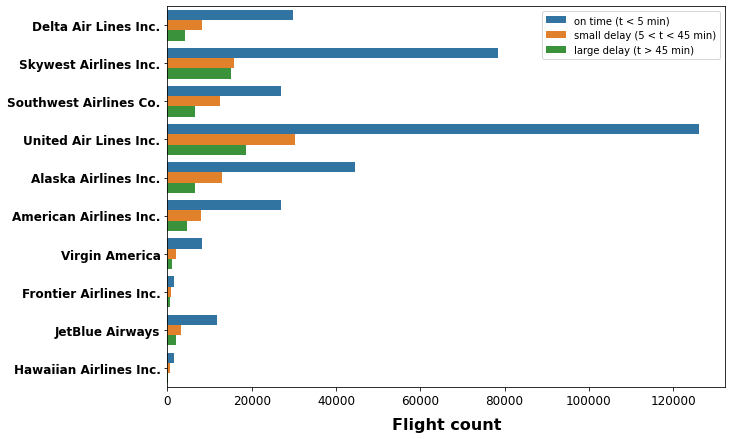

In [0]:
# large delays
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="OP_CARRIER", hue='DEL_LEVEL', data=df_base)
labels = [name_dict[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)

plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)

plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)

L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.show()

In [0]:
airport_mean_delays = pd.DataFrame(pd.Series(df_base['ORIGIN'].unique()))
airport_mean_delays.set_index(0, drop = True, inplace = True)
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
  
for carrier in name_dict.keys():
    df1 = df_base[df_base['OP_CARRIER'] == carrier]
    if len(df1)==0:
      pass
    else:
      test = df1['DEP_DELAY_NEW'].groupby(df_base['ORIGIN']).apply(get_stats).unstack()
      airport_mean_delays[carrier] = test.loc[:, 'mean'] 

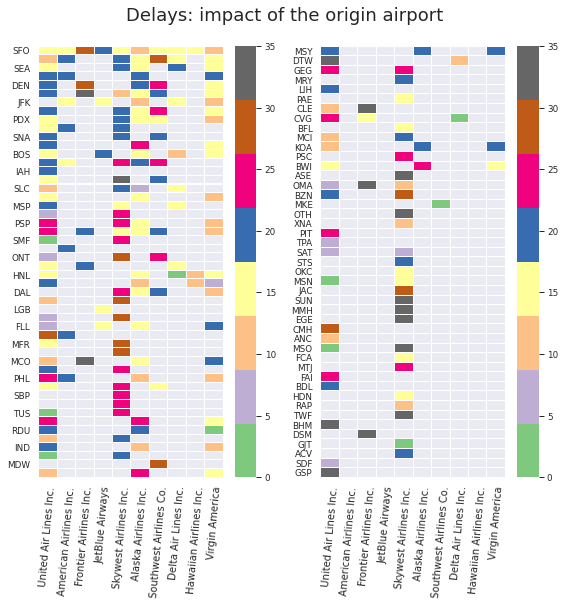

In [0]:
sns.set(context="paper")
fig = plt.figure(1, figsize=(8,8))

ax = fig.add_subplot(1,2,1)
subset = airport_mean_delays.iloc[:50,:].rename(columns =name_dict)
subset = subset.rename(index = airport_dict)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

ax = fig.add_subplot(1,2,2)    
subset = airport_mean_delays.iloc[50:100,:].rename(columns = name_dict)
subset = subset.rename(index = airport_dict)
fig.text(0.5, 1.02, "Delays: impact of the origin airport", ha='center', fontsize = 18)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

plt.tight_layout()


In [0]:
## Following is upon the the particular airport within the time window selected

In [0]:
#departure delay by day of week & FL_path
tripVertices = airlines.withColumnRenamed("DAY_OF_WEEK", "id").select("id").distinct()
tripEdges = airlines.select(col("DAY_OF_WEEK").alias("D_Week"),col("DEP_DELAY").alias("delay"), col("ORIGIN").alias("src"), col("DEST").alias("dst"),col("DEP_DEL15").alias("del15"), col("FLIGHT_PATH").alias("path"))

tripGraph2 = GraphFrame(tripVertices,tripEdges)
display(tripGraph2.edges.filter((col("src") == lit(airport_code)) & (col("delay") > 0))\
        .groupBy("D_Week","path")\
        .agg(count("del15"))\
        .sort(desc("count(del15)")))

D_Week path count(del15) 5 SFO-LAX 3411 4 SFO-LAX 3307 1 SFO-LAX 3124 7 SFO-LAX 3048 3 SFO-LAX 2648 2 SFO-LAX 2228 5 SFO-ORD 2164 4 SFO-ORD 2138 1 SFO-ORD 2054 3 SFO-ORD 1930 7 SFO-ORD 1842 2 SFO-ORD 1828 4 SFO-JFK 1815 5 SFO-JFK 1806 1 SFO-SEA 1793 5 SFO-SEA 1790 6 SFO-LAX 1765 4 SFO-SEA 1757 1 SFO-JFK 1692 7 SFO-JFK 1635 7 SFO-SEA 1616 3 SFO-JFK 1590 2 SFO-JFK 1501 5 SFO-BOS 1459 6 SFO-ORD 1419 4 SFO-BOS 1405 1 SFO-BOS 1380 3 SFO-SEA 1371 2 SFO-SEA 1350 3 SFO-BOS 1233 7 SFO-BOS 1225 6 SFO-SEA 1188 2 SFO-BOS 1176 5 SFO-IAH 1144 1 SFO-IAH 1078 5 SFO-DEN 1055 4 SFO-DEN 1038 7 SFO-IAH 1017 4 SFO-IAH 1015 1 SFO-DEN 985 7 SFO-DEN 951 6 SFO-JFK 942 4 SFO-DFW 933 1 SFO-DFW 928 3 SFO-IAH 927 5 SFO-ATL 919 5 SFO-DFW 913 4 SFO-ATL 911 2 SFO-IAH 900 6 SFO-BOS 894 3 SFO-DEN 890 1 SFO-ATL 876 3 SFO-ATL 852 2 SFO-DEN 848 7 SFO-DFW 830 3 SFO-DFW 826 6 SFO-IAH 810 7 SFO-ATL 807 2 SFO-DFW 781 2 SFO-ATL 681 6 SFO-DEN 658 6 SFO-DFW 645 6 SFO-ATL 561 4 SFO-CLT 315 5 SFO-CLT 306 1 SFO-CLT 302 3 SFO-CLT 270 7 SFO-CLT 266 2 SFO-CLT 234 1 SFO-DCA 211 5 SFO-DCA 210 6 SFO-CLT 208 7 SFO-DCA 190 4 SFO-DCA 168 4 SFO-CVG 165 2 SFO-DCA 164 6 SFO-DCA 160 7 SFO-CVG 150 3 SFO-DCA 149 1 SFO-CVG 123 5 SFO-CVG 118 2 SFO-CVG 113 3 SFO-CVG 111 6 SFO-CVG 62

In [0]:
#arrival delay by day of week & FL_path
tripVertices = airlines.withColumnRenamed("UNI_ID", "id").select("id").distinct()
tripEdges = airlines.select(col("DAY_OF_WEEK").alias("D_Week"),col("DEP_DELAY").alias("delay"), col("ORIGIN").alias("src"), col("DEST").alias("dst"),col("ARR_DEL15").alias("del15"), col("FLIGHT_PATH").alias("path"))

tripGraph2 = GraphFrame(tripVertices,tripEdges)
display(tripGraph2.edges.filter((col("dst") == lit(airport_code)) & (col("delay") > 0))\
        .groupBy("D_Week","path")\
        .agg(count("del15"))\
        .sort(desc("count(del15)")))

D_Week path count(del15) 5 LAX-SFO 3669 1 LAX-SFO 3497 4 LAX-SFO 3473 7 LAX-SFO 3263 3 LAX-SFO 3006 2 LAX-SFO 2595 5 ORD-SFO 2587 4 ORD-SFO 2584 1 ORD-SFO 2581 3 ORD-SFO 2328 7 ORD-SFO 2309 2 ORD-SFO 2225 1 SEA-SFO 1877 6 ORD-SFO 1843 6 LAX-SFO 1826 4 SEA-SFO 1807 5 SEA-SFO 1801 3 SEA-SFO 1542 7 SEA-SFO 1530 1 BOS-SFO 1520 5 BOS-SFO 1517 2 SEA-SFO 1492 4 BOS-SFO 1469 5 JFK-SFO 1459 1 JFK-SFO 1449 7 JFK-SFO 1442 7 BOS-SFO 1415 4 JFK-SFO 1394 2 BOS-SFO 1344 4 IAH-SFO 1303 3 BOS-SFO 1294 4 DEN-SFO 1266 2 JFK-SFO 1261 3 JFK-SFO 1257 5 IAH-SFO 1251 5 DEN-SFO 1250 1 DEN-SFO 1228 7 IAH-SFO 1222 1 IAH-SFO 1181 6 SEA-SFO 1180 7 DEN-SFO 1157 3 IAH-SFO 1157 4 DFW-SFO 1152 5 DFW-SFO 1152 5 ATL-SFO 1137 1 DFW-SFO 1125 4 ATL-SFO 1112 6 IAH-SFO 1081 1 ATL-SFO 1077 6 BOS-SFO 1071 2 DEN-SFO 1069 3 DEN-SFO 1062 7 DFW-SFO 1058 2 IAH-SFO 1023 3 DFW-SFO 1022 7 ATL-SFO 989 3 ATL-SFO 979 2 DFW-SFO 966 6 JFK-SFO 913 2 ATL-SFO 879 6 DEN-SFO 863 6 DFW-SFO 819 6 ATL-SFO 769 1 CLT-SFO 447 5 CLT-SFO 438 7 CLT-SFO 436 4 CLT-SFO 408 3 CLT-SFO 385 6 CLT-SFO 382 2 CLT-SFO 374 1 DCA-SFO 196 5 DCA-SFO 193 4 DCA-SFO 183 3 DCA-SFO 180 6 DCA-SFO 178 7 DCA-SFO 173 2 DCA-SFO 162 7 CVG-SFO 135 4 CVG-SFO 128 5 CVG-SFO 121 1 CVG-SFO 109 2 CVG-SFO 101 3 CVG-SFO 92 6 CVG-SFO 78

In [0]:
# Dep delay by destinations
tripVertices = airlines.withColumnRenamed("FL_PATH", "id").select("id").distinct()
tripEdges = airlines.select(col("FL_PATH").alias("path"),col("DEP_DELAY").alias("delay"), col("ORIGIN").alias("src"), col("DEST").alias("dst"))

tripGraph = GraphFrame(tripVertices,tripEdges)
display(tripGraph.edges.filter((col("dst") == lit(airport_code)) & (col("delay") > 0))\
        .groupBy("D_Week","src")\
        .agg(count("delay"))\
        .sort(desc("count(delay)")))


D_Week src count(delay) 4 LAX 3105 1 LAX 3053 7 LAX 3011 5 LAX 2844 2 LAX 2647 3 LAX 2608 4 SFO 2017 5 SFO 1951 6 LAX 1883 1 SFO 1878 7 SFO 1798 3 SFO 1774 2 SFO 1653 5 BOS 1093 4 BOS 1084 1 BOS 1081 6 SFO 1054 3 BOS 1034 2 BOS 1012 7 BOS 926 5 ATL 905 1 ATL 899 6 BOS 861 4 ATL 859 3 ATL 790 7 ATL 781 2 ATL 766 6 ATL 738 5 ORD 635 5 CLT 632 4 ORD 621 7 CLT 605 4 CLT 602 1 CLT 598 1 ORD 583 7 ORD 576 7 SEA 565 4 SEA 563 2 ORD 563 5 SEA 559 3 ORD 552 2 CLT 548 3 CLT 530 1 SEA 512 6 CLT 504 6 ORD 497 3 SEA 493 2 SEA 475 6 SEA 429 5 DCA 348 5 DFW 328 1 DCA 321 4 DCA 298 4 DFW 295 2 DCA 295 1 DFW 294 7 DCA 291 3 DCA 272 3 DFW 267 2 DFW 258 7 DFW 237 6 DFW 209 6 DCA 194 1 DEN 138 7 DEN 136 4 DEN 134 5 DEN 125 3 DEN 123 2 DEN 112 6 DEN 99 1 CVG 88 2 CVG 84 4 CVG 80 5 CVG 80 3 CVG 66 7 CVG 65 6 CVG 52 3 IAH 17 5 IAH 17 4 IAH 14 2 IAH 13 1 IAH 13 7 IAH 11 6 IAH 9

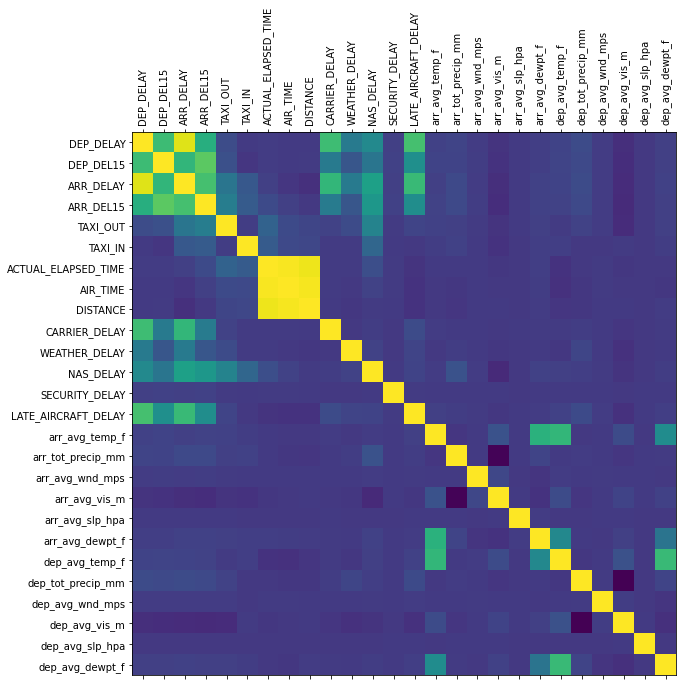

In [0]:
# OVERALL CORRELATION MATRIX

from pyspark.sql.types import StringType, DoubleType
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, warnings, scipy 

import plotly.offline as py
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from plotly import tools
from plotly.subplots import make_subplots

def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.'''
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
dep_num=[f.name for f in airlines.schema.fields if isinstance(f.dataType, DoubleType)]
df_num = airlines.select(dep_num).toPandas()
plot_corr(df_num)

In [0]:
# Dew point is the temperature at which the air becomes saturated (100 percent relative humidity).
# Security Delay - caused by evacuation of a terminal or concourse, re-boarding of aircraft because of security breach, inoperative screening equipment and/or long lines in excess of 29 minutes at screening areas.
# Weather Delay - caused by extreme or hazardous weather conditions that are forecasted or manifest themselves on point of departure, enroute, or on point of arrival.
# NAS Delay - within the control of the National Airspace System (NAS) may include: non-extreme weather conditions, airport operations, heavy traffic volume, air traffic control, etc. 
# Carrier Delay - within the control of the air carrier. Examples of occurrences that may determine carrier delay are: aircraft cleaning, aircraft damage, awaiting the arrival of connecting passengers or crew, baggage, bird strike, cargo loading, catering, computer, outage-carrier equipment, crew legality (pilot or attendant rest), damage by hazardous goods, engineering inspection, fueling, handling disabled passengers, late crew, lavatory servicing, maintenance, oversales, potable water servicing, removal of unruly passenger, slow boarding or seating, stowing carry-on baggage, weight and balance delays.
# Late-arriving aircraft: A previous flight with same aircraft arrived late, causing the present flight to depart late.


In [0]:
# should not run - this is a back-end data set
from pyspark.sql.functions import *
from pyspark.sql.types import *
#airport_code = "SFO"
#df_airlines = spark.read.option("header", "true").parquet( GROUP_DATA_PATH + "airlines_"+airport_code + ".parquet")
#df_airlines.createOrReplaceTempView('airlines')
#air_schema = df_airlines.schema
#print(GROUP_DATA_PATH + "airlines_"+airport_code + ".parquet")
#df_airlines = df_airlines.withColumn("dep_time", date_trunc('hour', "CRS_DEP_TIMESTAMP")).withColumn("arr_time", date_trunc('hour', "CRS_ARR_TIMESTAMP")).withColumn("FL_PATH", f.concat(f.col("ORIGIN"),f.lit("-"),f.col("DEST"))).withColumn('ORIGIN_CITY', split(col('ORIGIN_CITY_NAME'),",")[0]).withColumn('DEST_CITY', split(col('DEST_CITY_NAME'),",")[0])

DEP_HOUR ARR_HOUR FLIGHT_PATH ORIGIN_AIRPORT_ID DEST_AIRPORT_ID MONTH DAY_OF_MONTH DAY_OF_WEEK FL_DATE ORIGIN DEST CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK TAXI_OUT WHEELS_OFF WHEELS_ON TAXI_IN CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DEL15 ARR_DELAY_GROUP ARR_TIME_BLK CRS_ELAPSED_TIME ACTUAL_ELAPSED_TIME AIR_TIME DISTANCE DISTANCE_GROUP CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY arr_avg_temp_f arr_tot_precip_mm arr_avg_wnd_mps arr_avg_vis_m arr_avg_slp_hpa arr_avg_dewpt_f dep_avg_temp_f dep_tot_precip_mm dep_avg_wnd_mps dep_avg_vis_m dep_avg_slp_hpa dep_avg_dewpt_f 2017-08-20T11:00:00.000+0000 2017-08-20T13:00:00.000+0000 ATL-BOS 10397 10721 8 20 7 2017-08-20 ATL BOS 1125 1126 1.0 0.0 0 1100-1159 13.0 1139 1336 7.0 1359 1343 -16.0 0.0 -2 1300-1359 154.0 137.0 117.0 946.0 4 null null null null null 78.97999999999999 0.0 7.7 16093.0 1013.3 59.0 75.02000000000001 0.0 0.0 16093.0 1017.7 68.0 2018-05-08T22:00:00.000+0000 2018-05-08T00:00:00.000+0000 ATL-BOS 10397 10721 5 8 2 2018-05-08 ATL BOS 2220 2220 0.0 0.0 0 2200-2259 15.0 2235 40 5.0 55 45 -10.0 0.0 -1 0001-0559 155.0 145.0 125.0 946.0 4 null null null null null 50.0 0.0 2.6 16093.0 1021.9 46.94 71.06 0.3 4.1 16093.0 1018.2 59.0 2017-08-20T13:00:00.000+0000 2017-08-20T15:00:00.000+0000 ATL-BOS 10397 10721 8 20 7 2017-08-20 ATL BOS 1330 1326 -4.0 0.0 -1 1300-1359 10.0 1336 1535 5.0 1614 1540 -34.0 0.0 -2 1600-1659 164.0 134.0 119.0 946.0 4 null null null null null 82.03999999999999 0.0 4.6 16093.0 1014.0 60.980000000000004 84.92 0.0 0.0 16093.0 1018.8 66.92 2018-05-08T08:00:00.000+0000 2018-05-08T11:00:00.000+0000 ATL-BOS 10397 10721 5 8 2 2018-05-08 ATL BOS 820 822 2.0 0.0 0 0800-0859 14.0 836 1102 6.0 1055 1108 13.0 0.0 0 1000-1059 155.0 166.0 146.0 946.0 4 null null null null null 46.04 0.0 0.0 402.0 1025.9 46.04 64.03999999999999 0.0 6.7 16093.0 1017.8 53.96 2017-08-20T19:00:00.000+0000 2017-08-20T21:00:00.000+0000 ATL-BOS 10397 10721 8 20 7 2017-08-20 ATL BOS 1933 1926 -7.0 0.0 -1 1900-1959 12.0 1938 2142 8.0 2215 2150 -25.0 0.0 -2 2200-2259 162.0 144.0 124.0 946.0 4 null null null null null 82.03999999999999 0.0 6.7 16093.0 1015.7 53.06 89.96000000000001 0.0 1.5 16093.0 1017.5 64.94 2018-05-08T13:00:00.000+0000 2018-05-08T15:00:00.000+0000 ATL-BOS 10397 10721 5 8 2 2018-05-08 ATL BOS 1320 1333 13.0 0.0 0 1300-1359 7.0 1340 1539 8.0 1555 1547 -8.0 0.0 -1 1500-1559 155.0 134.0 119.0 946.0 4 null null null null null 50.0 0.0 3.6 16093.0 1025.7 48.019999999999996 68.0 0.0 4.1 16093.0 1020.6 60.08 2017-08-06T10:00:00.000+0000 2017-08-06T12:00:00.000+0000 ATL-BOS 10397 10721 8 6 7 2017-08-06 ATL BOS 1025 1025 0.0 0.0 0 1000-1059 13.0 1038 1234 7.0 1300 1241 -19.0 0.0 -2 1300-1359 155.0 136.0 116.0 946.0 4 null null null null null 66.92 0.0 8.8 16093.0 1014.6 51.08 71.96000000000001 0.0 1.5 16093.0 1017.4 64.03999999999999 2018-05-12T11:00:00.000+0000 2018-05-12T14:00:00.000+0000 ATL-BOS 10397 10721 5 12 6 2018-05-12 ATL BOS 1140 1139 -1.0 0.0 -1 1100-1159 13.0 1152 1411 9.0 1415 1420 5.0 0.0 0 1400-1459 155.0 161.0 139.0 946.0 4 null null null null null 50.0 0.0 4.1 12875.0 1023.6 42.980000000000004 71.96000000000001 0.0 0.0 16093.0 1020.5 64.03999999999999 2017-08-06T22:00:00.000+0000 2017-08-06T01:00:00.000+0000 ATL-BOS 10397 10721 8 6 7 2017-08-06 ATL BOS 2223 2223 0.0 0.0 0 2200-2259 48.0 2311 106 7.0 100 113 13.0 0.0 0 0001-0559 157.0 170.0 115.0 946.0 4 null null null null null 73.03999999999999 0.0 5.1 16093.0 1010.6 71.06 82.94 0.0 3.1 16093.0 1015.7 71.06 2018-05-12T20:00:00.000+0000 2018-05-12T22:00:00.000+0000 ATL-BOS 10397 10721 5 12 6 2018-05-12 ATL BOS 1945 2012 27.0 1.0 1 1900-1959 14.0 2026 2247 8.0 2225 2255 30.0 1.0 2 2200-2259 160.0 163.0 141.0 946.0 4 27.0 0.0 3.0 0.0 0.0 48.92 0.5 2.1 4828.0 1019.9 48.019999999999996 89.06 0.0 5.1 16093.0 1018.2 60.08 2017-08-06T16:00:00.000+0000 2017-08-06T19:00:00.000+0000 ATL-BOS 10397 10721 8 6 7 2017-08-06 ATL BOS 1622 1646 24.0 1.0 1 1600-1659 19.0 1705 1906 6.0

In [0]:
#group_air_path = GROUP_DATA_PATH + "/airlines_"+airport_code+".delta"
#df_air = test.writeStream.format("delta").trigger(processingTime="1 second").option('checkpointLocation', #air_base_path + "/_checkpoint").start(group_air_path)
